In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Exercise 1. PyTorch I

In [2]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [3]:
labels_map = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
              'Sneaker', 'Bag', 'Ankle Boot']

In [4]:
train_dataset = datasets.FashionMNIST('fashion_data',
                        train=True,
                        transform=transforms.ToTensor(),
                        download=True)
test_dataset = datasets.FashionMNIST('fashion_data',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size, shuffle=True)

In [6]:
examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)

In [7]:
images.shape

torch.Size([100, 1, 28, 28])

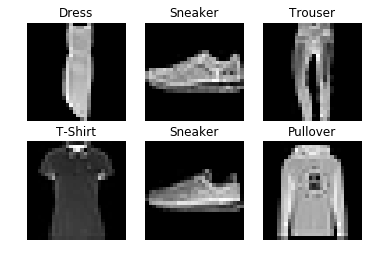

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i][0], cmap='gray')
    label = labels[i].item()
    plt.title(labels_map[label])
    plt.axis('off')

In [9]:
class CNN(nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            #depth=1, K=16, P=(5-1)/2, S=1, out=28x28x16 
            nn.Conv2d(1, 16, kernel_size=5, padding=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)) #14x14x16
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2), #14x14x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)) #7x7x32
        self.fc = nn.Linear(7*7*32, num_class)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
def train():
    model = CNN(len(labels_map))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    ce_loss = nn.CrossEntropyLoss()
    
    losses = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.float())
            labels = Variable(labels)
            
            outputs = model(images)
            loss = ce_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if (i+1)%10 == 0:
                losses.append(loss.item());
            
            if (i+1)%100 == 0:
                print('Loss: ', np.around(loss.item(), 4), 'epoch: ', epoch, '/',num_epochs)
    return model, losses

In [11]:
model, losses = train()

Loss:  3.3919 epoch:  0 / 5
Loss:  1.7809 epoch:  0 / 5
Loss:  1.6518 epoch:  0 / 5
Loss:  1.4683 epoch:  0 / 5
Loss:  1.2712 epoch:  0 / 5
Loss:  0.9792 epoch:  0 / 5
Loss:  1.1489 epoch:  1 / 5
Loss:  1.2382 epoch:  1 / 5
Loss:  1.3059 epoch:  1 / 5
Loss:  1.1806 epoch:  1 / 5
Loss:  1.1379 epoch:  1 / 5
Loss:  0.9194 epoch:  1 / 5
Loss:  0.999 epoch:  2 / 5
Loss:  0.9097 epoch:  2 / 5
Loss:  0.9051 epoch:  2 / 5
Loss:  0.8768 epoch:  2 / 5
Loss:  0.9539 epoch:  2 / 5
Loss:  0.6961 epoch:  2 / 5
Loss:  0.8392 epoch:  3 / 5
Loss:  1.1812 epoch:  3 / 5
Loss:  0.7145 epoch:  3 / 5
Loss:  0.9577 epoch:  3 / 5
Loss:  1.235 epoch:  3 / 5
Loss:  1.0709 epoch:  3 / 5
Loss:  0.5512 epoch:  4 / 5
Loss:  0.7027 epoch:  4 / 5
Loss:  1.305 epoch:  4 / 5
Loss:  0.859 epoch:  4 / 5
Loss:  1.4273 epoch:  4 / 5
Loss:  1.0776 epoch:  4 / 5


In [35]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for image, label in test_loader:
        image = Variable(image.float())
        output = model(image)
        predicted = torch.argmax(output, dim=1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        accuracy = 100 * correct / total        
    return accuracy

In [36]:
accuracy = test(model, test_loader)
print('Accuracy: ', accuracy)

Accuracy:  73.54


Text(0.5,1,'Loss over training steps')

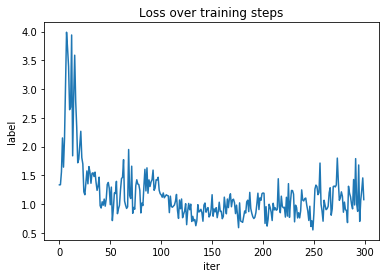

In [37]:
plt.plot(losses)
plt.xlabel('iter')
plt.ylabel('label')
plt.title('Loss over training steps')

## Exercise 2. PyTorch II

### (b)
Download a pretrained model from torchvision and use it as a feature extractor for CIFAR-10. This is called transfer learning. Try finetuning the pretrained model by unfreezing (parts of) the network. Note that you have to resize the data.

In [15]:
test_dataset_cif = datasets.CIFAR10('cifar10',
                        train=False,
                        transform=transforms.Compose([
                            transforms.Resize(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                        ]),
                        download=True)

Files already downloaded and verified


In [16]:
test_loader_cif = DataLoader(dataset=test_dataset_cif, batch_size=batch_size, shuffle=True)

In [19]:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [41]:
vgg = models.vgg19(pretrained=True)
features = vgg.features
print(features)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/evabertalan/.torch/models/vgg19-dcbb9e9d.pth
100.0%


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 